# Facial Expressions Detection 




<a name="importing-the-libraries"></a>
## **Importing the Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


<a name="prepare-dataset"></a>
## **Prepare dataset**

In [2]:
df = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
# check the column name in df
for col in df.columns:
    print(col)

emotion
 Usage
 pixels


In [4]:
# remove space in front of the name
df.columns = df.columns.str.replace(' ', '')

**check 'usage' type and split into different dataset**

In [5]:
# check how many 'usage' type
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [6]:
# check how many 'emotion' type
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [7]:
# split data
train_df = df[df['Usage'] == 'Training'].copy()
validation_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy()

print(train_df.shape)
print(validation_df.shape)
print(validation_df.shape)

(28709, 3)
(3589, 3)
(3589, 3)


**check image size**

In [8]:
image_size = int(math.sqrt(len(df['pixels'][0].split(' '))))
print(image_size)

48


In [9]:
def load_data(dataset):
    label_array = []
    image_array = []
    for index, row in dataset.iterrows():
        label_array.append(row['emotion'])
        
        # covert str to int
        img_arr = row['pixels'].split(' ')
        img_arr = np.array(img_arr).astype(int)
                    
        image_array.append(img_arr)
        
    return label_array, image_array

In [10]:
def view_data_image(dataset):
    plt.figure(figsize= (5,5))

    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        
        img_arr = dataset[i]
        img_arr = img_arr.reshape((image_size, image_size))
        
        plt.imshow(img_arr, cmap='gray')
    plt.show()

**Training Data**

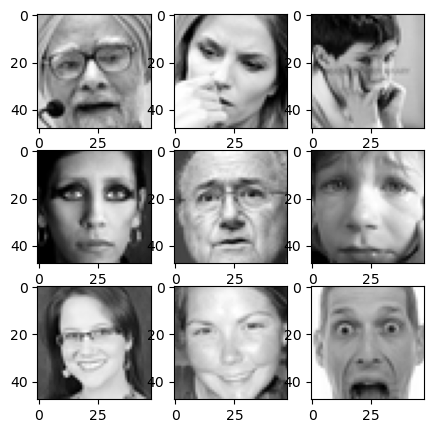

(28709, 2304)
(28709,)
(28709, 48, 48, 1)
(28709,)


In [11]:
# split training images and labels
train_label, train_image = load_data(train_df)

# visual image
view_data_image(train_image)

# convert list to numpy 
train_images = np.array(train_image).astype('float32')
print(train_images.shape)

train_labels = np.array(train_label).astype('int32')
print(train_labels.shape)

# convert numpy to tensor
train_images = np.array(train_image)
train_images = train_images.reshape((train_images.shape[0], 48, 48, 1))
print(train_images.shape)

train_labels = np.array(train_label)
print(train_labels.shape)

**validation data**

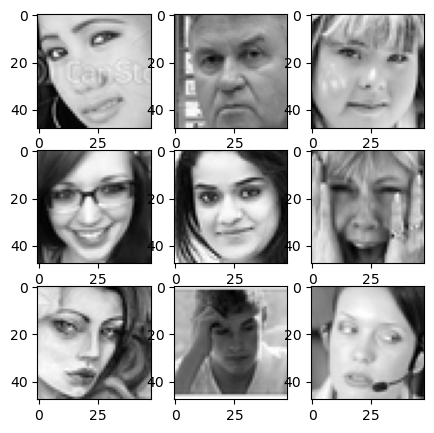

(3589, 2304)
(3589,)
(3589, 48, 48, 1)
(3589,)


In [12]:
# split validation images and labels
validation_label, validation_image = load_data(validation_df)

# visual image
view_data_image(validation_image)

# convert list to numpy 
validation_images = np.array(validation_image).astype('float32')
print(validation_images.shape)

validation_labels = np.array(validation_label).astype('int32')
print(validation_labels.shape)

# convert numpy to tensor
validation_images = np.array(validation_image)
validation_images = validation_images.reshape((validation_images.shape[0], 48, 48, 1))
print(validation_images.shape)

validation_labels = np.array(validation_label)
print(validation_labels.shape)

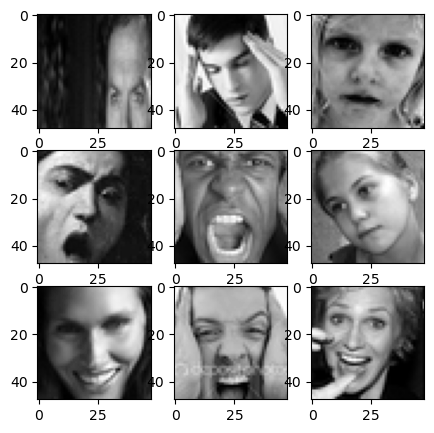

(3589, 2304)
(3589,)
(3589, 48, 48, 1)
(3589,)


In [13]:
# split testing images and labels
test_label, test_image = load_data(test_df)

# visual image
view_data_image(test_image)

# convert list to numpy 
test_images = np.array(test_image).astype('float32')
print(test_images.shape)

test_labels = np.array(test_label).astype('int32')
print(test_labels.shape)

# convert numpy to tensor
test_images = np.array(test_image)
test_images = test_images.reshape((test_images.shape[0], 48, 48, 1))
print(test_images.shape)

test_labels = np.array(test_label)
print(test_labels.shape)

In [14]:
from tensorflow.keras.utils import to_categorical

# one-hot encoding
train_labels = to_categorical(train_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

<a name="create-dataloader"></a>
## **Create dataloader**

In [15]:
batch_size = 32

In [16]:
def show_dataloader_image(dataset):
    plt.figure(figsize=(5, 5))
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in dataset:
            image = X_batch[0]
            plt.imshow(image, cmap='gray')
            break
    plt.tight_layout()
    plt.show()


**Training dataloader**

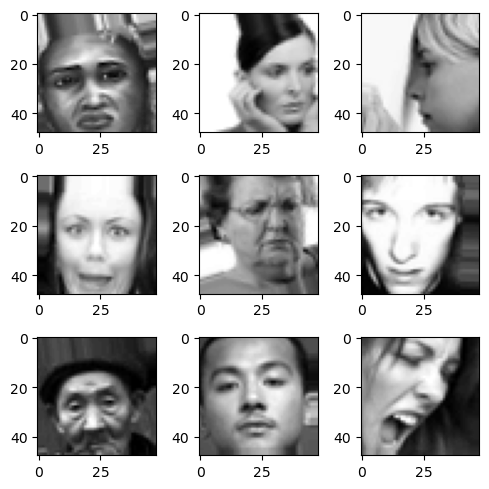

In [17]:
# training generator
datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.2,1.0),
                                    rescale=1./255,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,)

train_set = datagen_train.flow(train_images,
                                train_labels,
                                batch_size = batch_size,
                                shuffle = True)

# view dataloader
show_dataloader_image(train_set)

**Validation dataloader**

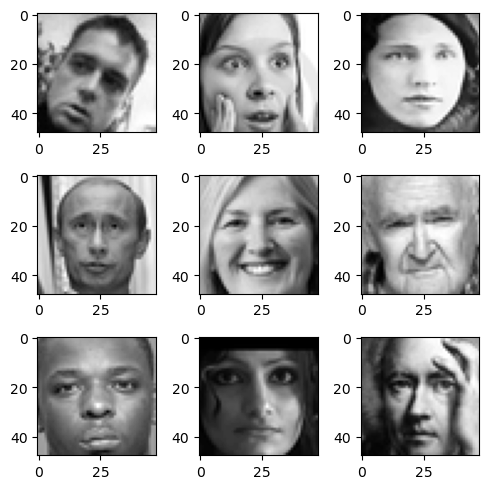

In [18]:
# validation generator
datagen_test = ImageDataGenerator(rescale=1./255)

validation_set = datagen_test.flow(validation_images,
                                validation_labels,
                                batch_size = batch_size,
                                shuffle = True)

# view dataloader
show_dataloader_image(validation_set)

**Testing dataloader**

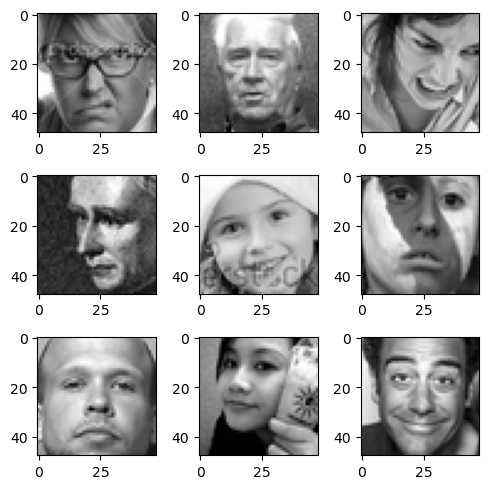

In [19]:
# validation generator
test_set = datagen_test.flow(test_images,
                                test_labels,
                                batch_size = batch_size,
                                shuffle = False)

# view dataloader
show_dataloader_image(test_set)

<a name="model-and-training"></a>
## **Model and Training**

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks_list = [early_stopping, reduce_learningrate]
epochs = 50


In [21]:
def cnn_model():
  model = Sequential()

  # Block 1
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1), name="conv1_1"))
  model.add(BatchNormalization(name='batchnorm_1'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name="conv1_2"))
  model.add(BatchNormalization(name='batchnorm_2'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_1"))
  model.add(Dropout(0.3, name='dropout_1'))
  
  # Block 2
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_1"))
  model.add(BatchNormalization(name='batchnorm_3'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_2"))
  model.add(BatchNormalization(name='batchnorm_4'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_2"))
  model.add(Dropout(0.3, name='dropout_2'))

  # Block 3
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_1"))
  model.add(BatchNormalization(name='batchnorm_5'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_2"))
  model.add(BatchNormalization(name='batchnorm_6'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_3"))
  model.add(BatchNormalization(name='batchnorm_7'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_3"))
  model.add(Dropout(0.3, name='dropout_3'))

  # Block 4
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_1"))
  model.add(BatchNormalization(name='batchnorm_8'))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_2"))
  model.add(BatchNormalization(name='batchnorm_9'))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_3"))
  model.add(BatchNormalization(name='batchnorm_10'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_4"))
  model.add(Dropout(0.3, name='dropout_4'))
    
  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(256, activation='relu', name="fc_3"))
  model.add(Dense(128, activation='relu', name="fc_4"))
  model.add(Dropout(0.6, name='dropout_5'))
  model.add(Dense(7, activation='softmax', name='output'))

  return model

In [22]:
model_1 = cnn_model()
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [23]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_model_1 = model_1.fit(train_set, 
                              epochs=epochs, 
                              validation_data=validation_set, 
                              callbacks=callbacks_list, 
                              verbose=1)


Epoch 1/50


2023-04-15 16:20:30.875337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


898/898 [==============================] - 53s 42ms/step - loss: 1.9953 - accuracy: 0.2052 - val_loss: 1.8342 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 2/50
898/898 [==============================] - 39s 43ms/step - loss: 1.8588 - accuracy: 0.2337 - val_loss: 1.8155 - val_accuracy: 0.2435 - lr: 1.0000e-04
Epoch 3/50
898/898 [==============================] - 39s 43ms/step - loss: 1.8438 - accuracy: 0.2436 - val_loss: 1.7977 - val_accuracy: 0.2510 - lr: 1.0000e-04
Epoch 4/50
898/898 [==============================] - 39s 43ms/step - loss: 1.8304 - accuracy: 0.2463 - val_loss: 1.7983 - val_accuracy: 0.2533 - lr: 1.0000e-04
Epoch 5/50
898/898 [==============================] - 39s 44ms/step - loss: 1.8267 - accuracy: 0.2510 - val_loss: 1.7969 - val_accuracy: 0.2494 - lr: 1.0000e-04
Epoch 6/50
898/898 [==============================] - 39s 44ms/step - loss: 1.8088 - accuracy: 0.2587 - val_loss: 1.7190 - val_accuracy: 0.2873 - lr: 1.0000e-04
Epoch 7/50
898/898 [=========================

<a name="evaluation-the-model-on-test-set"></a>
## **Evaluation the Model on Test Set**

In [24]:
def plot_model_history(model_history):
    # Plotting the accuracies
    dict_hist = model_history.history

    list_ep = [i for i in range(1, len(dict_hist['accuracy']) + 1)]

    plt.figure(figsize = (8, 8))

    plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

    plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

    plt.ylabel('Accuracy')

    plt.xlabel('Epochs')

    plt.legend()

    plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

def check_model_performance(model, testing_data):
    test_pred = model.predict(testing_data)
    test_pred = np.argmax(test_pred, axis = -1)

    y_true_labels = testing_data.y
    y_true_labels = np.argmax(y_true_labels, axis = -1)
    
    print(classification_report(y_true_labels, test_pred))

    cm = confusion_matrix(y_true_labels, test_pred)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f')

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()



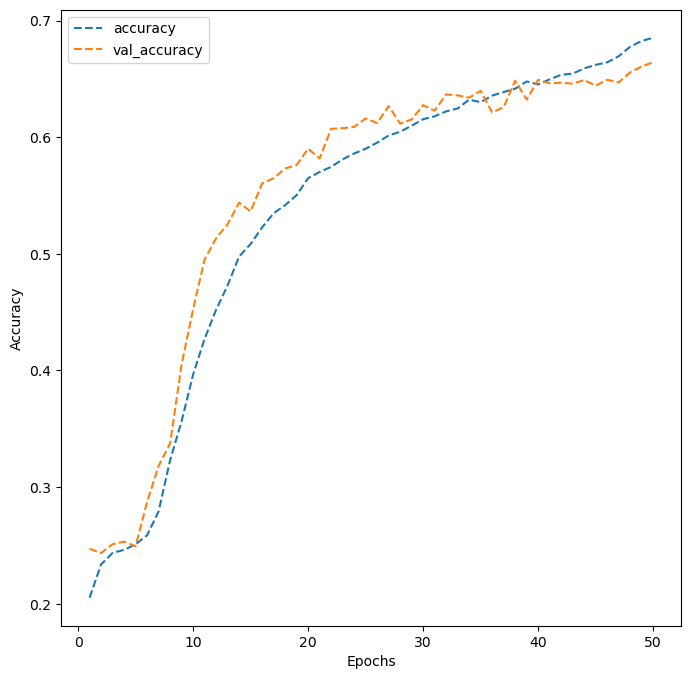

113/113 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       491
           1       0.66      0.49      0.56        55
           2       0.54      0.36      0.43       528
           3       0.89      0.88      0.89       879
           4       0.57      0.47      0.51       594
           5       0.70      0.81      0.75       416
           6       0.56      0.75      0.64       626

    accuracy                           0.66      3589
   macro avg       0.64      0.63      0.63      3589
weighted avg       0.66      0.66      0.66      3589



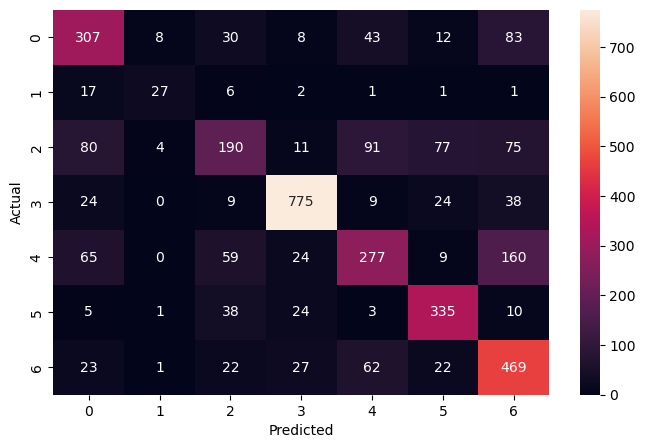

In [26]:
plot_model_history(history_model_1)
check_model_performance(model_1, test_set)

In [27]:
model_1.save('model_1.h5')
